In [15]:
# --- Imports & I/O setup ---
import os, json, pathlib, textwrap
from datetime import datetime

import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, log_loss, roc_curve,
                             precision_recall_curve, confusion_matrix,
                             f1_score)
import matplotlib.pyplot as plt

import joblib

# xgboost is optional; notebook will still run without it
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# Paths
os.makedirs("artifacts", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Repro
RNG = 42
np.random.seed(RNG)


In [16]:
# --- Load dataset & feature list (CSV- or Parquet-aware, robust) ---
import json, pathlib, pandas as pd

sf_path = pathlib.Path("data/storage_format.json")
fmt = "csv"
if sf_path.exists():
    raw = json.loads(sf_path.read_text(encoding="utf-8"))
    # handle dict OR list-of-dicts
    if isinstance(raw, dict):
        recs = [raw]
    elif isinstance(raw, list):
        recs = [r for r in raw if isinstance(r, dict)]
    else:
        recs = []
    if recs:
        # choose the last record (most recent write)
        fmt = recs[-1].get("format", "csv").lower()

# Load df according to format, with a safe fallback
if fmt == "parquet":
    try:
        df = pd.read_parquet("data/df_nb02.parquet")
    except Exception as e:
        print("Parquet not available, falling back to CSV:", e)
        df = pd.read_csv("data/df_nb02.csv", parse_dates=["date"])
else:
    df = pd.read_csv("data/df_nb02.csv", parse_dates=["date"])

# Load the feature list
feat_path = pathlib.Path("artifacts/feature_list.json")
if not feat_path.exists():
    raise FileNotFoundError("artifacts/feature_list.json missing (run NB2 to export feature list).")
feat_cols = json.loads(feat_path.read_text(encoding="utf-8"))

# Take intersection with df columns
feat_cols = [c for c in feat_cols if c in df.columns]

# Params (optional)
lp = pathlib.Path("data/label_params.json")
TAU = DEAD_ZONE = None
if lp.exists():
    lpj = json.loads(lp.read_text(encoding="utf-8"))
    TAU = float(lpj.get("tau")) if "tau" in lpj else None
    DEAD_ZONE = bool(lpj.get("dead_zone")) if "dead_zone" in lpj else None

# Quick peek
print("Rows/Features:", len(df), "/", len(feat_cols), "| fmt:", fmt)
df[["date"] + feat_cols[:5]].head()


Rows/Features: 2686 / 16 | fmt: csv


,date,close,high,low,macd,macd_signal
0,2015-02-06,26.495501,26.789573,26.388564,0.616322,0.436495
1,2015-02-09,26.671507,26.698240,26.384117,0.633757,0.475947
2,2015-02-10,27.183905,27.212867,26.769531,0.681070,0.516972
3,2015-02-11,27.821064,27.829975,27.290843,0.761204,0.565818
4,2015-02-12,28.173059,28.400298,27.974783,0.843393,0.621333


In [17]:
# --- Ensure label exists; clean features; time-based split ---
from sklearn.preprocessing import StandardScaler

# 1) Find or build the label
label_candidates = ["y", "target", "label", "y_next_up"]
label_col = next((c for c in label_candidates if c in df.columns), None)

if label_col is None:
    # Try to build next-day direction from ret1 if available
    if "ret1" not in df.columns:
        raise RuntimeError("No label column found and 'ret1' is missing; run Notebook 02 to create labels.")
    df["y"] = (df["ret1"].shift(-1) > 0).astype(int)
    df = df.dropna(subset=["y"]).copy()
    label_col = "y"
    print("Label 'y' created from next-day ret1 sign.")
elif label_col != "y":
    df["y"] = df[label_col].astype(int)

# 2) Make sure feature list does NOT contain the label or obvious non-features
drop_feats = set(["y", "target", "label", "y_next_up", "date", "ticker", "symbol"])
feat_cols = [c for c in feat_cols if c in df.columns and c not in drop_feats]
# numeric only
feat_cols = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c])]

# 3) Sort by time and split 60/20/20
df = df.sort_values("date").reset_index(drop=True)
n = len(df)
n_train = int(0.6 * n)
n_val   = int(0.2 * n)
n_test  = n - n_train - n_val

df_tr = df.iloc[:n_train].copy()
df_va = df.iloc[n_train:n_train+n_val].copy()
df_te = df.iloc[n_train+n_val:].copy()

X_tr, y_tr = df_tr[feat_cols].values, df_tr["y"].values
X_va, y_va = df_va[feat_cols].values, df_va["y"].values
X_te, y_te = df_te[feat_cols].values, df_te["y"].values

# 4) Standardize (fit on train only)
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_va_s = scaler.transform(X_va)
X_te_s = scaler.transform(X_te)

print("Features:", len(feat_cols))
print("Splits:", df_tr.shape, df_va.shape, df_te.shape)
print("Label balance (train/val/test):",
      y_tr.mean().round(3), y_va.mean().round(3), y_te.mean().round(3))


Features: 16
Splits: (1611, 22) (537, 22) (538, 22)
Label balance (train/val/test): 0.529 0.514 0.548


In [18]:
# --- Train models ---
lr = LogisticRegression(max_iter=200, n_jobs=None, solver="lbfgs", random_state=RNG)
lr.fit(X_tr_s, y_tr)

if HAVE_XGB:
    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        random_state=RNG,
        eval_metric="logloss",
        n_jobs=0
    )
    xgb.fit(X_tr, y_tr)  # XGB often does better without standardization
else:
    xgb = None

print("Trained LR", "| XGB:", HAVE_XGB)


Trained LR | XGB: True


In [19]:
# --- Validation metrics to choose threshold later ---
def metric_block(y_true, y_prob):
    p = np.clip(np.asarray(y_prob), 1e-15, 1 - 1e-15)
    return {
        "AUC": roc_auc_score(y_true, p),
        "PR_AUC": average_precision_score(y_true, p),
        "Brier": brier_score_loss(y_true, p),
        "LogLoss": log_loss(y_true, p)
    }

preds = {}
preds["LR"] = {
    "va": lr.predict_proba(X_va_s)[:, 1],
    "te": lr.predict_proba(X_te_s)[:, 1],
}

if HAVE_XGB:
    preds["XGB"] = {
        "va": xgb.predict_proba(X_va)[:, 1],
        "te": xgb.predict_proba(X_te)[:, 1],
}

rows = []
for model_name, d in preds.items():
    m_va = metric_block(y_va, d["va"])
    m_te = metric_block(y_te, d["te"])
    rows.append({"model": model_name, "split": "val", **m_va, "PosRate": float(np.mean(y_va))})
    rows.append({"model": model_name, "split": "test", **m_te, "PosRate": float(np.mean(y_te))})

summary = pd.DataFrame(rows)
summary.to_csv("data/explainability_summary.csv", index=False)
summary


,model,split,AUC,PR_AUC,Brier,LogLoss,PosRate
0,LR,val,0.458257,0.488295,0.261855,0.718123,0.513966
1,LR,test,0.478998,0.520235,0.254662,0.702503,0.548327
2,XGB,val,0.511328,0.528512,0.277136,0.758238,0.513966
3,XGB,test,0.474534,0.522771,0.287053,0.775793,0.548327


In [20]:
# --- Choose thresholds on VALIDATION by Youden's J and MCC (and compare to max-F1) ---
from sklearn.metrics import (
    confusion_matrix, matthews_corrcoef, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_curve
)

p_va = preds["LR"]["va"]; p_te = preds["LR"]["te"]

# Youden J from ROC
fpr, tpr, thr = roc_curve(y_va, p_va)
j_scores = tpr - fpr
t_j = float(thr[j_scores.argmax()])

# MCC grid
grid = np.linspace(0.05, 0.95, 181)
mcc_vals = [matthews_corrcoef(y_va, (p_va >= t).astype(int)) for t in grid]
t_mcc = float(grid[int(np.argmax(mcc_vals))])

# (Optional) F1 for comparison
f1_vals = [f1_score(y_va, (p_va >= t).astype(int)) for t in grid]
t_f1 = float(grid[int(np.argmax(f1_vals))])

print(f"Youden J thr={t_j:.3f} | MCC thr={t_mcc:.3f} | F1 thr={t_f1:.3f}")

# Pick your default threshold for the rest of NB5:
t_star = t_j    # <- or t_mcc if you prefer

def eval_at(t):
    yhat = (p_te >= t).astype(int)
    return {
        "thr": round(t,3),
        "BalAcc": balanced_accuracy_score(y_te, yhat),
        "F1": f1_score(y_te, yhat, zero_division=0),
        "Prec": precision_score(y_te, yhat, zero_division=0),
        "Rec": recall_score(y_te, yhat, zero_division=0),
        "CM": confusion_matrix(y_te, yhat).tolist()
    }

print("TEST @ Youden J:", eval_at(t_j))
print("TEST @ MCC     :", eval_at(t_mcc))
print("TEST @ F1      :", eval_at(t_f1))
print("Using t_star =", round(t_star, 3))


Youden J thr=0.447 | MCC thr=0.755 | F1 thr=0.050
TEST @ Youden J: {'thr': 0.447, 'BalAcc': 0.5031317569923973, 'F1': 0.675392670157068, 'Prec': 0.5501066098081023, 'Rec': 0.8745762711864407, 'CM': [[32, 211], [37, 258]]}
TEST @ MCC     : {'thr': 0.755, 'BalAcc': 0.5, 'F1': 0.0, 'Prec': 0.0, 'Rec': 0.0, 'CM': [[243, 0], [295, 0]]}
TEST @ F1      : {'thr': 0.05, 'BalAcc': 0.5020576131687243, 'F1': 0.7091346153846154, 'Prec': 0.5493482309124768, 'Rec': 1.0, 'CM': [[1, 242], [0, 295]]}
Using t_star = 0.447


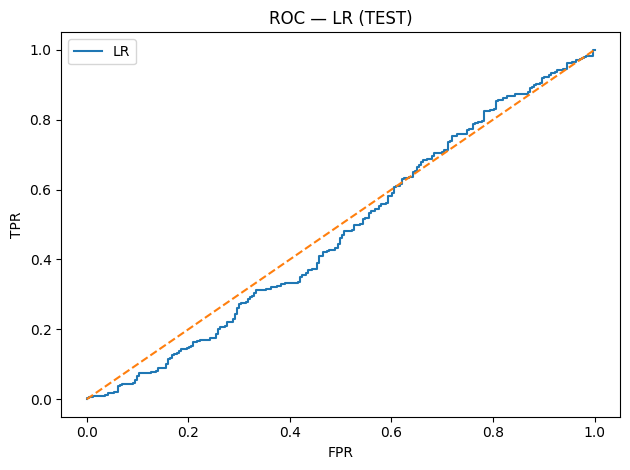

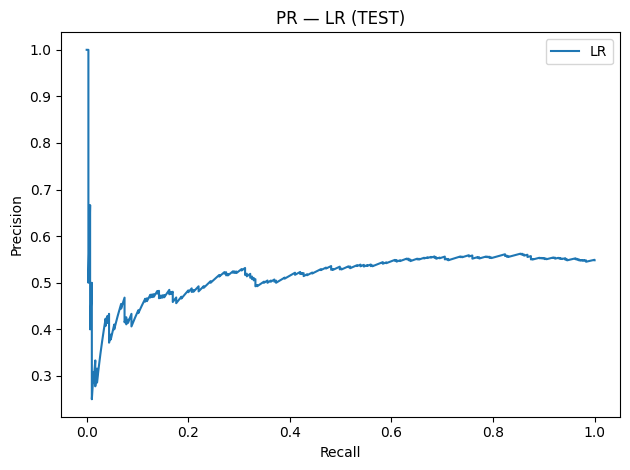

In [21]:
# --- ROC & PR curves (LR only for plots to keep it simple) ---
fpr, tpr, _ = roc_curve(y_te, preds["LR"]["te"])
prec, rec, _ = precision_recall_curve(y_te, preds["LR"]["te"])

plt.figure()
plt.plot(fpr, tpr, label="LR")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/roc_nb05.png", dpi=140)
plt.show()

plt.figure()
plt.plot(rec, prec, label="LR")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — LR (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/pr_nb05.png", dpi=140)
plt.show()


C:\Users\ybh11\AppData\Local\Temp\ipykernel_4952\3720636791.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df_te.assign(prob=preds["LR"]["te"]).groupby(binned).agg(


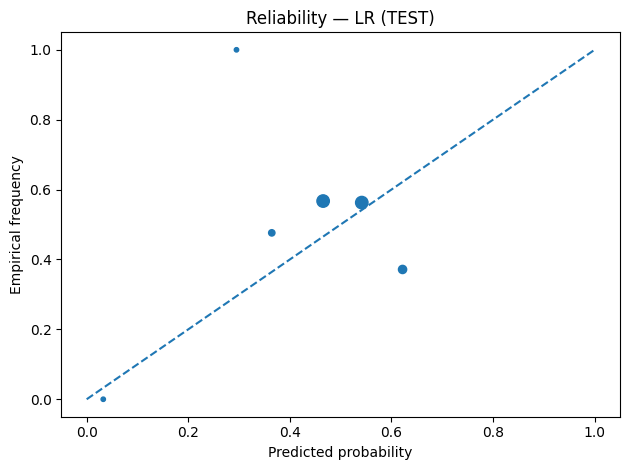

Brier (LR):  0.2546618285974668
Brier (XGB): 0.2870526607090878


In [22]:
# --- Reliability (Calibration) curve & Brier ---
bins = np.linspace(0,1,11)
binned = pd.cut(preds["LR"]["te"], bins=bins, include_lowest=True)
cal = df_te.assign(prob=preds["LR"]["te"]).groupby(binned).agg(
    mean_prob=("prob","mean"), mean_true=("y","mean"), count=("y","size")
).dropna()

plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.scatter(cal["mean_prob"], cal["mean_true"], s=np.clip(cal["count"], 10, 80))
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("Reliability — LR (TEST)")
plt.tight_layout()
plt.savefig("reports/figures/reliability_lr_nb05.png", dpi=140)
plt.show()

print("Brier (LR): ", brier_score_loss(y_te, preds["LR"]["te"]))
if HAVE_XGB:
    print("Brier (XGB):", brier_score_loss(y_te, preds["XGB"]["te"]))


In [23]:
# --- Choose threshold on validation to maximize F1, then evaluate on TEST ---
ths = np.linspace(0.05, 0.95, 181)
f1s = [f1_score(y_va, (preds["LR"]["va"] >= t).astype(int)) for t in ths]
t_star = float(ths[int(np.argmax(f1s))])

yhat_test = (preds["LR"]["te"] >= t_star).astype(int)
cm = pd.DataFrame(confusion_matrix(y_te, yhat_test),
                  index=pd.Index([0,1], name="Actual"),
                  columns=pd.Index([0,1], name="Pred"))
print(f"LR threshold* (val max-F1): {t_star:.3f}")
cm


LR threshold* (val max-F1): 0.050


Pred,0,1
Actual,,
0,1,242
1,0,295


C:\Users\ybh11\AppData\Local\Temp\ipykernel_4952\2535673095.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_year = df_te_eval.groupby("year").apply(


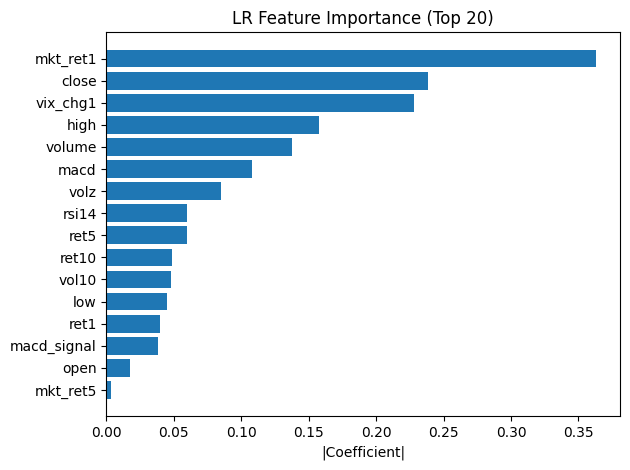

,feature,coef,abs_coef
0,mkt_ret1,-0.362679,0.362679
1,close,-0.238603,0.238603
2,vix_chg1,-0.227845,0.227845
3,high,0.157696,0.157696
4,volume,-0.137643,0.137643
5,macd,0.108249,0.108249
6,volz,0.084944,0.084944
7,rsi14,-0.059415,0.059415
8,ret5,0.059358,0.059358
9,ret10,0.048909,0.048909


In [24]:
# --- Stability by year (TEST) & LR coefficients ---
df_te_eval = df_te.copy()
df_te_eval["prob_lr"] = preds["LR"]["te"]
df_te_eval["year"] = pd.to_datetime(df_te_eval["date"]).dt.year

by_year = df_te_eval.groupby("year").apply(
    lambda g: pd.Series({
        "AUC": roc_auc_score(g["y"], g["prob_lr"]) if g["y"].nunique() > 1 else np.nan,
        "Brier": brier_score_loss(g["y"], g["prob_lr"]),
        "PosRate": float(g["y"].mean())
    })
)
by_year.to_csv("data/metrics_by_year_LR.csv")
by_year

# LR "importance" = absolute coefficient magnitude
coef = pd.Series(lr.coef_.ravel(), index=feat_cols).sort_values(key=np.abs, ascending=False)
imp_tbl = (pd.DataFrame({"feature": coef.index, "coef": coef.values})
             .assign(abs_coef=lambda d: d["coef"].abs()))
topk = imp_tbl.head(20).reset_index(drop=True)
topk.to_csv("data/lr_importance_topk.csv", index=False)

plt.figure()
plt.barh(topk["feature"][::-1], topk["abs_coef"][::-1])
plt.xlabel("|Coefficient|")
plt.title("LR Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("reports/figures/lr_feature_importance_topk.png", dpi=140)
plt.show()

imp_tbl.head(10)


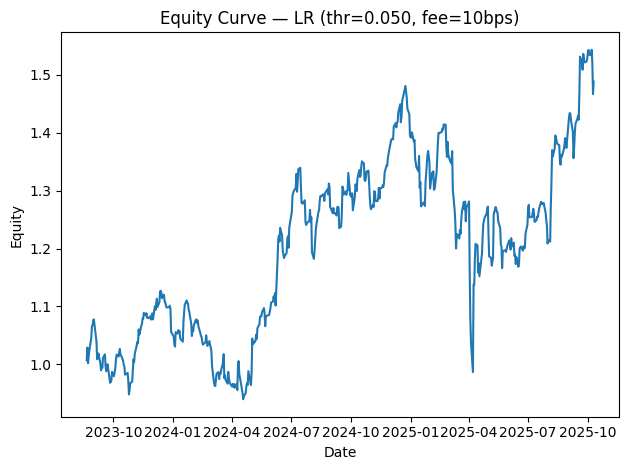

CAGR          0.2047
Vol           0.2747
Sharpe        0.7451
MaxDD        -0.3336
HitRate       0.5483
Trades        3.0000
TurnoverYr    1.4052
dtype: float64

In [25]:
# --- Backtest: long-only when prob >= t_star (with fees & trade counting) ---
FEE_BPS = 10  # 10 bps one-way cost; change if you’d like
fee = FEE_BPS / 10000.0

df_bt = df_te_eval.copy()
if "ret_next" not in df_bt.columns:
    if "close" in df_bt.columns:
        df_bt["ret_next"] = df_bt["close"].pct_change().shift(-1)
    else:
        raise ValueError("No 'ret_next' or 'close' column found for backtest.")

signal = (df_bt["prob_lr"] >= t_star).astype(int).values
flips  = (np.abs(np.diff(np.r_[0, signal])) > 0).astype(int)  # trade when position changes
cost   = flips * fee

strat_ret = signal * df_bt["ret_next"].values - cost
equity = (1 + pd.Series(strat_ret).fillna(0)).cumprod()

def kpis(r, freq=252):
    r = pd.Series(r).fillna(0)
    cagr = (1 + r).prod() ** (freq / max(len(r),1)) - 1
    vol  = r.std() * np.sqrt(freq)
    sharpe = (cagr / vol) if vol > 0 else np.nan
    eq = (1 + r).cumprod()
    maxdd = (eq / eq.cummax() - 1).min()
    hit = (r > 0).mean()
    trades = int(flips.sum())
    turn_yr = flips.mean() * freq
    return pd.Series({"CAGR":cagr, "Vol":vol, "Sharpe":sharpe, "MaxDD":maxdd, "HitRate":hit, "Trades":trades, "TurnoverYr":turn_yr})

bt_stats = kpis(strat_ret)
plt.figure()
plt.plot(df_bt["date"], equity)
plt.title(f"Equity Curve — LR (thr={t_star:.3f}, fee={FEE_BPS}bps)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.tight_layout()
plt.savefig("reports/figures/equity_curve_lr.png", dpi=140)
plt.show()

bt_stats.round(4)


In [26]:
# --- Save artifacts ---
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(lr, "artifacts/lr.joblib")
with open("artifacts/threshold.json","w",encoding="utf-8") as f:
    json.dump({"threshold": t_star}, f, indent=2)
print("Saved scaler, lr, and threshold.")


Saved scaler, lr, and threshold.


In [27]:
# --- Model Card: write 'reports/model_card.md' (robust + no tabulate) ---
from datetime import datetime, UTC
import json, pathlib, pandas as pd

def df_to_md(tbl: pd.DataFrame, index=False, floatfmt=".4f"):
    df2 = tbl.copy()
    if not index and df2.index.name is not None:
        df2 = df2.reset_index()
    for col in df2.columns:
        if pd.api.types.is_float_dtype(df2[col]):
            df2[col] = df2[col].map(lambda x: f"{x:{floatfmt}}" if pd.notnull(x) else "")
    headers = list(map(str, df2.columns))
    lines = ["| " + " | ".join(headers) + " |",
             "| " + " | ".join(["---"] * len(headers)) + " |"]
    for _, row in df2.iterrows():
        lines.append("| " + " | ".join(map(str, row.values)) + " |")
    return "\n".join(lines)

def _safe_read_csv(path, required_cols=None, fallback_rows=None):
    p = pathlib.Path(path)
    if p.exists():
        try:
            df = pd.read_csv(p)
            if required_cols and not set(required_cols).issubset(df.columns):
                raise ValueError(f"{path} missing required cols {required_cols}")
            return df
        except Exception as e:
            print(f"Warning: failed to read {path}: {e}")
    return pd.DataFrame(fallback_rows or [])

def fmt_opt(x, fmt=".3f"):
    try:
        return format(float(x), fmt)
    except Exception:
        return "N/A"

# expects 'df' and 'feat_cols' already defined earlier in NB5
TICKER = (df["ticker"].iloc[0] if "ticker" in df.columns and len(df) else "UNK")
START  = str(pd.to_datetime(df["date"]).min().date())
END    = str(pd.to_datetime(df["date"]).max().date())

# optional label params
TAU = DEAD_ZONE = None
lp = pathlib.Path("data/label_params.json")
if lp.exists():
    lpj = json.loads(lp.read_text(encoding="utf-8"))
    TAU = lpj.get("tau", None)
    DEAD_ZONE = lpj.get("dead_zone", None)

# threshold.json (handles multiple schemas)
t_star = None
thr_p = pathlib.Path("artifacts/threshold.json")
if thr_p.exists():
    tj = json.loads(thr_p.read_text(encoding="utf-8"))
    if isinstance(tj, dict):
        if "LR" in tj and isinstance(tj["LR"], dict) and "tau" in tj["LR"]:
            t_star = tj["LR"]["tau"]
        elif "threshold" in tj:
            t_star = tj["threshold"]
        elif "tau" in tj:
            t_star = tj["tau"]
t_star_str = fmt_opt(t_star, ".3f")

# small tables (tolerate missing)
card_tbl = _safe_read_csv(
    "data/explainability_summary.csv",
    fallback_rows=[{"model":"LR","split":"test","AUC":"","PR_AUC":"","Brier":"","LogLoss":"","PosRate":""}]
)
by_year_tbl = _safe_read_csv(
    "data/metrics_by_year_LR.csv",
    fallback_rows=[{"year":"","AUC":"","Sharpe":"","TotalReturn":""}]
)

today_utc = datetime.now(UTC).date().isoformat()
labeling_str = f"tau={fmt_opt(TAU)}, dead_zone={DEAD_ZONE}" if TAU is not None else "from NB5 settings"
feat_preview = ", ".join(feat_cols[:12]) + (" ..." if len(feat_cols) > 12 else "")

card = f"""# Model Card — Stock Direction (LogReg)
**Date:** {today_utc}  
**Ticker:** {TICKER} | **Period:** {START} → {END}  
**Labeling:** {labeling_str}  
**Features ({len(feat_cols)}):** {feat_preview}

## Metrics (Val/Test summary)
{df_to_md(card_tbl, index=False, floatfmt=".4f")}

**Val-chosen threshold:** {t_star_str}

## Stability (test by year)
{df_to_md(by_year_tbl, index=False, floatfmt=".4f")}

## Artifacts
- `artifacts/scaler.joblib`, `artifacts/lr.joblib`, `artifacts/threshold.json`, `artifacts/feature_list.json`
- Curves: `reports/figures/roc_nb05.png`, `pr_nb05.png`, `reliability_lr_nb05.png`, `equity_curve_lr.png`
- Importance: `reports/figures/lr_feature_importance_topk.png`
"""

pathlib.Path("reports").mkdir(parents=True, exist_ok=True)
pathlib.Path("reports/model_card.md").write_text(card, encoding="utf-8")
print("Wrote reports/model_card.md")


Wrote reports/model_card.md


In [28]:
# --- Quick check of outputs ---
print("Artifacts:", list(pathlib.Path("artifacts").glob("*")))
print("Figures:",  list(pathlib.Path("reports/figures").glob("*.png")))
print("Data:",     [p for p in pathlib.Path("data").glob("*") if p.suffix in {'.csv','.parquet','.json'}])


Artifacts: [WindowsPath('artifacts/backtest_summary.json'), WindowsPath('artifacts/feature_list.json'), WindowsPath('artifacts/inversion.json'), WindowsPath('artifacts/lr.joblib'), WindowsPath('artifacts/lstm_nb3.pt'), WindowsPath('artifacts/lstm_scaler.joblib'), WindowsPath('artifacts/nb3_lstm_config.json'), WindowsPath('artifacts/nb3_split_info.json'), WindowsPath('artifacts/scaler.joblib'), WindowsPath('artifacts/test_target_dates.npy'), WindowsPath('artifacts/threshold.json'), WindowsPath('artifacts/train_target_dates.npy'), WindowsPath('artifacts/val_target_dates.npy'), WindowsPath('artifacts/walkforward_summary.json'), WindowsPath('artifacts/wf_backtest_summary.json')]
Figures: [WindowsPath('reports/figures/eda_close.png'), WindowsPath('reports/figures/eda_ret1_hist.png'), WindowsPath('reports/figures/equity_curve_lr.png'), WindowsPath('reports/figures/equity_curve_vs_buyhold.png'), WindowsPath('reports/figures/equity_curve_walkforward.png'), WindowsPath('reports/figures/lr_featu

In [29]:
# --- Compute & save metrics by calendar year on the TEST split (LogReg) ---
import json, pathlib
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss
from joblib import load

# 1) Load dataset (CSV/Parquet) and normalize dates
data_path = "data/df_nb02.parquet" if pathlib.Path("data/df_nb02.parquet").exists() else "data/df_nb02.csv"
df = pd.read_parquet(data_path) if data_path.endswith(".parquet") else pd.read_csv(data_path)
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# 2) Find or derive label (next-day up)
label_col = next((c for c in ["y","target","label","y_next_up"] if c in df.columns), None)
if label_col is None:
    # Prefer existing 1-day return; else reconstruct from a close column
    if "ret1" in df.columns:
        next_ret = df["ret1"].shift(-1)
    else:
        price_col = next((c for c in ["close","Close","Adj Close","adj_close"] if c in df.columns), None)
        if price_col is None:
            raise KeyError("No label column and no return/close price found to derive labels.")
        ret1 = pd.Series(df[price_col]).pct_change()
        next_ret = ret1.shift(-1)
    df["y"] = (next_ret > 0).astype(int)
    label_col = "y"

# 3) Load artifacts
feat_cols = json.load(open("artifacts/feature_list.json","r",encoding="utf-8"))
lr        = load("artifacts/lr.joblib")
scaler_p  = pathlib.Path("artifacts/scaler.joblib")
scaler    = load(scaler_p) if scaler_p.exists() else None

# Ensure all features exist; fill any missing as 0.0
for c in feat_cols:
    if c not in df.columns:
        df[c] = 0.0

# 4) Chronological split: 70/15/15 (train/val/test)
n = len(df)
i_tr = int(0.70*n)
i_va = int(0.85*n)
df_te = df.iloc[i_va:].copy()

X_te = df_te[feat_cols].to_numpy()
if scaler is not None:
    X_te = scaler.transform(X_te)

y_te = df_te[label_col].astype(int).to_numpy()
p_te = lr.predict_proba(X_te)[:, 1]

# 5) Group by calendar year and compute metrics
df_te["year"] = df_te["date"].dt.year
rows = []
for yr, g in df_te.groupby("year"):
    # Align to p_te positions: df_te keeps original index starting at i_va
    idx = g.index - df_te.index[0]
    y = g[label_col].astype(int).to_numpy()
    p = p_te[idx]
    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
    brier = brier_score_loss(y, p)
    pos   = float(y.mean())
    rows.append({"year": int(yr), "AUC": auc, "Brier": brier, "PosRate": pos})

by_year = pd.DataFrame(rows).sort_values("year")
pathlib.Path("data").mkdir(parents=True, exist_ok=True)
by_year.to_csv("data/metrics_by_year_LR.csv", index=False)
print("Wrote data/metrics_by_year_LR.csv — rows:", len(by_year))
display(by_year.head(10))


Wrote data/metrics_by_year_LR.csv — rows: 2


,year,AUC,Brier,PosRate
0,2024,0.489245,0.249921,0.607656
1,2025,0.410638,0.264317,0.515464
